# Project 2: Option Pricing

### Q1. Pick a stock of your choice which is being traded in the derivative market.

### stock chosen Apple Inc = (AAPL).

In [1]:
import yfinance as yf
def get_stock_details(ticker_symbol):
    try:
        stock = yf.Ticker(ticker_symbol)
        stock_info = stock.info
        print("Stock Details for", ticker_symbol)
        print("Name:", stock_info['longName'])
        print("Exchange:", stock_info['exchange'])
        print("Currency:", stock_info['currency'])
        print("Current Price:", stock_info['currentPrice'])
        print("Market Cap:", stock_info['marketCap'])
        print("Volume:", stock_info['volume'])
        print("Previous Close:", stock_info['previousClose'])
        print("Open:", stock_info['open'])
        print("Day's Range:", stock_info['dayLow'], "-", stock_info['dayHigh'])
        print("52 Week Range:", stock_info['fiftyTwoWeekLow'], "-", stock_info['fiftyTwoWeekHigh'])
    except Exception as e:
        print("Error:", str(e))

# print the stock details
get_stock_details('AAPL')

C:\Users\admin\anaconda3\lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


Stock Details for AAPL
Name: Apple Inc.
Exchange: NMS
Currency: USD
Current Price: 165.0
Market Cap: 2547913326592
Volume: 67326599
Previous Close: 167.04
Open: 166.12
Day's Range: 164.08 - 166.4
52 Week Range: 162.8 - 199.62


### Q2. Look at the stock’s and option’s history on YAHOO Finance.

In [2]:
# Input parameters
stock_symbol = 'AAPL'
start_date = '2023-04-16'
end_date = '2024-04-16'
stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
print(stock_data.head(20))

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-04-17  165.089996  165.389999  164.029999  165.229996  164.352722   
2023-04-18  166.100006  167.410004  165.649994  166.470001  165.586166   
2023-04-19  165.800003  168.160004  165.539993  167.630005  166.740005   
2023-04-20  166.089996  167.869995  165.559998  166.649994  165.765182   
2023-04-21  165.050003  166.449997  164.490005  165.020004  164.143875   
2023-04-24  165.000000  165.600006  163.889999  165.330002  164.452209   
2023-04-25  165.190002  166.309998  163.729996  163.770004  162.900497   
2023-04-26  163.059998  165.279999  162.800003  163.759995  162.890533   
2023-04-27  165.190002  168.559998  165.190002  168.410004  167.515854   
2023-04-28  168.490005  169.850006  167.880005  169.679993  168.779099   
2023-05-01  169.279999  170.449997  168.639999  169.589996  168.689575   
2023-05-02  170.089996  170.350006  16

### Q3. Use past one-year data to estimate the annual volatility.

In [3]:
import yfinance as yf
import numpy as np


def calculate_annual_volatility(stock_symbol, start_date, end_date):
    # Fetching historical data from Yahoo Finance
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
    closing_price = stock_data.tail(1)['Close'].values[0]

    # daily returns
    daily_returns = stock_data['Adj Close'].pct_change().dropna()

    # Calculating annual volatility
    annual_volatility = np.sqrt(252) * daily_returns.std()  # Assuming 252 trading days in a year

    return annual_volatility,closing_price

# Input parameters
stock_symbol = 'AAPL'
start_date = '2023-04-16'
end_date = '2024-04-16'


# annual volatility and closing price
volatility,closing_price = calculate_annual_volatility(stock_symbol, start_date, end_date)
print(f"Annual Volatility of {stock_symbol}: {volatility}")
print(f"closing price {stock_symbol}: {closing_price}")


[*********************100%%**********************]  1 of 1 completed

Annual Volatility of AAPL: 0.1959408491379502
closing price AAPL: 172.69000244140625


### Q4 .Use 10 years’ US treasury rate or any other rate as the rate of interest.

In [4]:
def get_interest_rate():
    # Fetching 10-year US Treasury rate from Yahoo Finance
    treasury_data = yf.download("^TNX", start=start_date, end=end_date)

    # Assuming the treasury_data contains only one row (latest data)
    interest_rate = treasury_data['Adj Close'].iloc[-1] / 100  # Convert percentage to decimal

    return interest_rate

# interest rate
interest_rate = get_interest_rate()
print(f"Risk-free Interest Rate: {interest_rate:.4f}")

[*********************100%%**********************]  1 of 1 completed

Risk-free Interest Rate: 0.0463


### Q5. Now fix the strike price and time of maturity to evaluate the call/ put option price by using one step Binomial model

# the current stock price is around 172.69 . choosing a strike price close to this level 160.0) 

In [5]:
# Input parameters for the option

S = round(closing_price, 4) # Current stock price
K = 160  # Strike price
T = 1  # Time to maturity (in years)
sigma = round(volatility, 4)   # Volatility
r = round(interest_rate, 4)  # Risk-free interest rate

In [6]:
def one_step_binomial_call(S, K, r, T, sigma):
    dt = T / 1  # Number of steps = 1 for one-step model
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Calculate option price using risk-neutral pricing formula
    Cu = max(0, S * u - K)
    Cd = max(0, S * d - K)
    option_price = np.exp(-r * dt) * (p * Cu + (1 - p) * Cd)

    return option_price



# option price using one-step binomial model
option_price_binomial = one_step_binomial_call(S, K, r, T, sigma)
print(f"call Option Price (One-Step Binomial Model): {option_price_binomial:.4f}")

call Option Price (One-Step Binomial Model): 27.3088


### Q6.Evaluate the option price by using Black Scholes Formula

In [7]:
import numpy as np
from scipy.stats import norm

def calculate_black_scholes_call(S, K, r, T, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return option_price


# option price using Black-Scholes formula
option_price_bs = calculate_black_scholes_call(S, K, r, T, sigma)
print(f"call Option Price (Black-Scholes Formula): {option_price_bs:.4f}")

call Option Price (Black-Scholes Formula): 25.0596


### Q7.Increase the number of steps in Binomial model to verify that the price converges to Q6.

In [8]:
# function to calculate option price using binomial model with n steps
def n_step_binomial_call(S, K, r, T, sigma, n):
    dt = T / n
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Calculate option price using risk-neutral pricing formula
    option_price = 0
    for i in range(n + 1):
        Cu = max(0, S * (u ** (n - i)) * (d ** i) - K)
        option_price += np.exp(-r * T) * np.math.comb(n, i) * (p ** (n - i)) * ((1 - p) ** i) * Cu

    return option_price

# Testing with different number of steps
n_steps = [10, 50, 100, 500, 1000]
for n in n_steps:
    option_price_binomial_n = n_step_binomial_call(S, K, r, T, sigma, n)
    print(f"call Option Price (Binomial Model with {n} steps): {option_price_binomial_n}")


call Option Price (Binomial Model with 10 steps): 25.295369800128363
call Option Price (Binomial Model with 50 steps): 25.101459572304005
call Option Price (Binomial Model with 100 steps): 25.043020854767544
call Option Price (Binomial Model with 500 steps): 25.063630624984146
call Option Price (Binomial Model with 1000 steps): 25.059649459498964


### Q8.Draw the graph to show Q7.

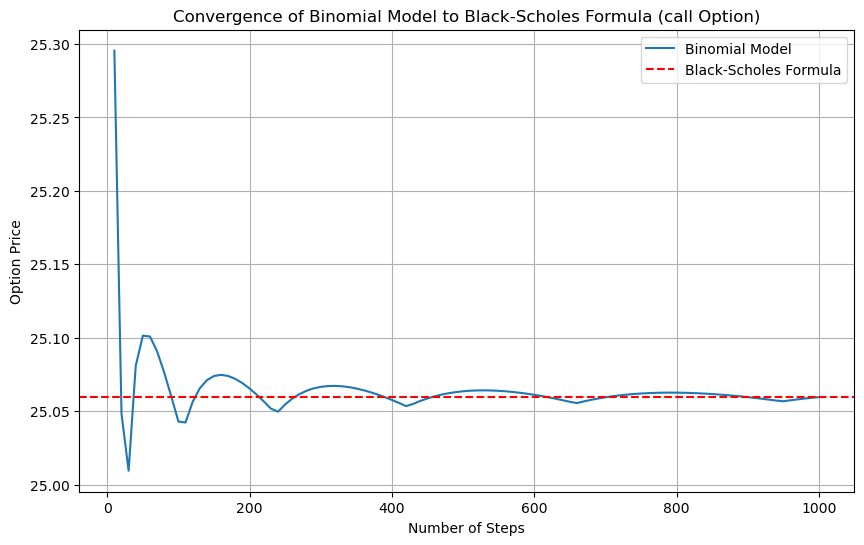

In [9]:
import matplotlib.pyplot as plt

# Define a function to calculate option price using binomial model with n steps
def n_step_binomial_call(S, K, r, T, sigma, n):
    # Calculation logic remains the same as before
    dt = T / n
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Calculate option price using risk-neutral pricing formula
    option_price = 0
    for i in range(n + 1):
        Cu = max(0, S * (u ** (n - i)) * (d ** i) - K)
        option_price += np.exp(-r * T) * np.math.comb(n, i) * (p ** (n - i)) * ((1 - p) ** i) * Cu

    return option_price

# Generate option prices using binomial model with different number of steps
n_steps = range(10, 1001, 10)
option_prices_binomial = [n_step_binomial_call(S, K, r, T, sigma, n) for n in n_steps]

# Plot the convergence
plt.figure(figsize=(10, 6))
plt.plot(n_steps, option_prices_binomial, label='Binomial Model')
plt.axhline(y=option_price_bs, color='r', linestyle='--', label='Black-Scholes Formula')
plt.xlabel('Number of Steps')
plt.ylabel('Option Price')
plt.title('Convergence of Binomial Model to Black-Scholes Formula (call Option)')
plt.legend()
plt.grid(True)
plt.show()


### Q9 How do you create a delta neutral portfolio?

In [10]:
import numpy as np
from scipy.stats import norm

def black_scholes_call(S, K, r, T, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return option_price

def black_scholes_call_delta(S, K, r, T, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    delta = norm.cdf(d1)
    return delta

def create_delta_neutral_portfolio(S, K, r, T, sigma, option_type, option_quantity):
    # Calculate the delta of the option
    delta_option = black_scholes_call_delta(S, K, r, T, sigma)
    
    # Calculate the number of options needed to hedge
    options_needed = option_quantity
    
    # Calculate the number of shares needed to hedge (opposite sign)
    shares_needed = -delta_option * option_quantity
    
    if option_type == 'put':
        options_needed = -option_quantity
        shares_needed = delta_option * option_quantity
    
    # Verify delta neutrality
    total_delta = shares_needed + (options_needed * delta_option)
    
    # Adjust the quantities of shares and options to make the total delta closer to zero
    if total_delta != 0:
        # Calculate the adjustment factor
        adjustment_factor = -total_delta / delta_option
        
        # Adjust the quantities of shares and options
        shares_needed += adjustment_factor
        options_needed += adjustment_factor * option_quantity
    
    # Return the adjusted number of shares, options, and total delta for the delta-neutral portfolio
    return shares_needed, options_needed, total_delta

option_type = 'call'  # 'call' or 'put'
option_quantity = 1  # Quantity of options in the portfolio

# Create delta-neutral portfolio
shares_needed, options_needed, total_delta = create_delta_neutral_portfolio(S, K, r, T, sigma, option_type, option_quantity)

# Output results
print(f"Shares needed for delta-neutral portfolio: {shares_needed:.4f}")
print(f"Options needed for delta-neutral portfolio: {options_needed}")
print(f"Total delta of the portfolio: {total_delta}")

Shares needed for delta-neutral portfolio: -0.7654
Options needed for delta-neutral portfolio: 1
Total delta of the portfolio: 0.0


### Q10.Use numerical methods to get implied volatility?

In [11]:
from scipy.stats import norm
from scipy.optimize import newton

def black_scholes_call(S, K, r, T, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return option_price

def implied_volatility(S, K, r, T, option_price, option_type):
    def black_scholes_call_iv(sigma):
        return black_scholes_call(S, K, r, T, sigma) - option_price

    if option_type == 'call':
        implied_vol = newton(black_scholes_call_iv, x0=0.3)
    elif option_type == 'put':
        implied_vol = newton(black_scholes_call_iv, x0=0.3)
    else:
        raise ValueError("Option type must be 'call' or 'put'.")

    return implied_vol


option_price = option_price_bs  # Observed market price of the option
option_type = 'call'  # 'call' or 'put'

# Calculate implied volatility
iv = implied_volatility(S, K, r, T, option_price, option_type)
print(f"Implied Volatility call option: {iv:.4f}")


Implied Volatility call option: 0.1959


### Q11.Calculate and interpret Option Greeks for a given option contract.

In [12]:
import numpy as np
from scipy.stats import norm

def black_scholes_call(S, K, r, T, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))    
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

def calculate_option_greeks(S, K, r, T, sigma):
    # Calculate Delta
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    delta = norm.cdf(d1)

    # Calculate Gamma
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))

    # Calculate Theta
    theta = -(S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf((d1 - sigma * np.sqrt(T)))

    # Calculate Vega
    vega = S * norm.pdf(d1) * np.sqrt(T)

    # Calculate Rho
    rho = K * T * np.exp(-r * T) * norm.cdf(d1)

    return delta, gamma, theta, vega, rho

# Calculate Option Greeks
call_price = black_scholes_call(S, K, r, T, sigma)
delta_value, gamma_value, theta_value,vega_value, rho_value = calculate_option_greeks(S, K, r, T, sigma)

# Interpretation
print(f"Call Price: {call_price:.2f}")
print(f"Delta: {delta_value:.4f}")
print(f"Gamma: {gamma_value:.4f}")
print(f"Theta: {theta_value:.4f}")
print(f"Vega: {vega_value:.4f}")
print(f"Rho: {rho_value:.4f}")


Call Price: 25.06
Delta: 0.7654
Gamma: 0.0091
Theta: -10.1525
Vega: 53.0132
Rho: 116.9289


### Q12.Visualize the impact of changes in underlying price, volatility, and time to expiration on Option Greeks.

### Calculate Option Greeks for different underlying prices

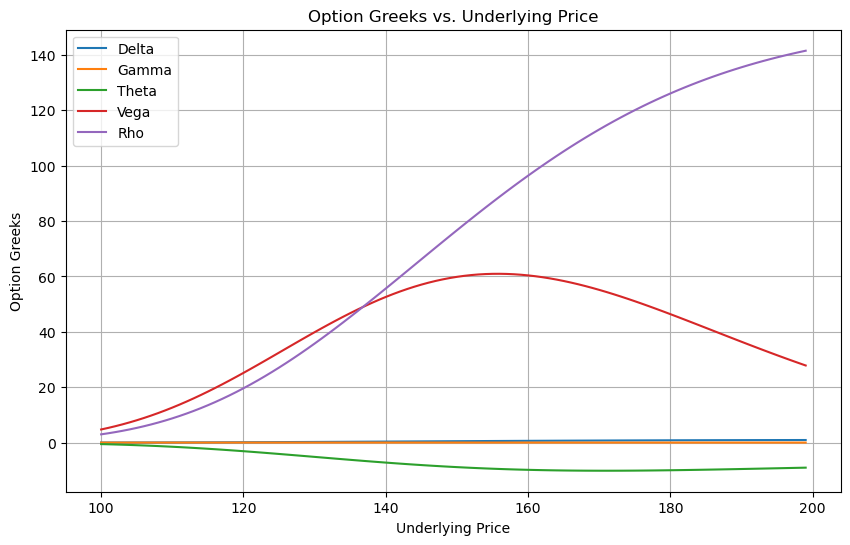

In [13]:
import numpy as np
import matplotlib.pyplot as plt


# Parameters
S_range = np.arange(100, 200, 1)  # Range of underlying prices
sigma_range = np.arange(0.1, 0.5, 0.01)  # Range of volatilities
T_range = np.arange(0.1, 2, 0.1)  # Range of time to expiration

# Calculate Option Greeks for different underlying prices
delta_S = []
gamma_S = []
theta_S = []
vega_S = []
rho_S = []

for S in S_range:   
    delta, gamma, theta, vega, rho = calculate_option_greeks(S,K, r, T, sigma)    
    delta_S.append(delta)
    gamma_S.append(gamma)
    theta_S.append(theta)
    vega_S.append(vega)
    rho_S.append(rho)
    

# Plot Option Greeks vs. Underlying Price
plt.figure(figsize=(10, 6))
plt.plot(S_range, delta_S, label='Delta')
plt.plot(S_range, gamma_S, label='Gamma')
plt.plot(S_range, theta_S, label='Theta')
plt.plot(S_range, vega_S, label='Vega')
plt.plot(S_range, rho_S, label='Rho')
plt.xlabel('Underlying Price')
plt.ylabel('Option Greeks')
plt.title('Option Greeks vs. Underlying Price')
plt.legend()
plt.grid(True)
plt.show()



### Calculate Option Greeks for different volatilities

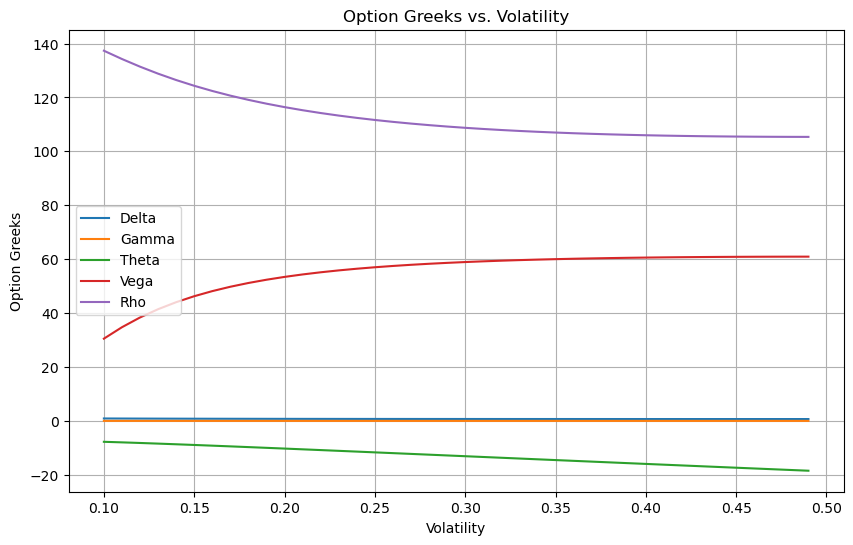

In [14]:
S = closing_price
delta_sigma = []
gamma_sigma = []
theta_sigma = []
vega_sigma = []
rho_sigma = []

for sigma in sigma_range:    
    delta, gamma, theta, vega, rho = calculate_option_greeks(S,K,r, T, sigma)
    delta_sigma.append(delta)
    gamma_sigma.append(gamma)
    theta_sigma.append(theta)
    vega_sigma.append(vega)
    rho_sigma.append(rho)

# Plot Option Greeks vs. Volatility
plt.figure(figsize=(10, 6))
plt.plot(sigma_range, delta_sigma, label='Delta')
plt.plot(sigma_range, gamma_sigma, label='Gamma')
plt.plot(sigma_range, theta_sigma, label='Theta')
plt.plot(sigma_range, vega_sigma, label='Vega')
plt.plot(sigma_range, rho_sigma, label='Rho')
plt.xlabel('Volatility')
plt.ylabel('Option Greeks')
plt.title('Option Greeks vs. Volatility')
plt.legend()
plt.grid(True)
plt.show()




### Calculate Option Greeks for different times to expiration

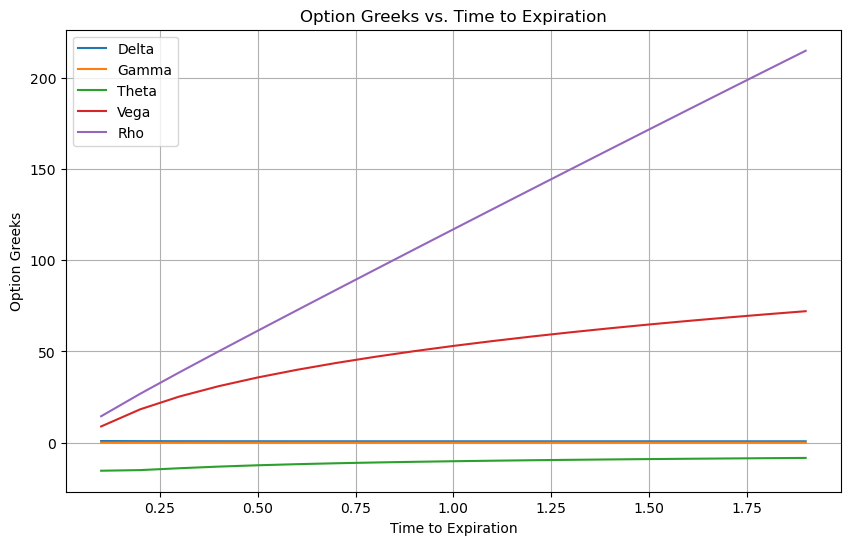

In [15]:
S= closing_price
sigma = volatility  # Volatility
delta_T = []
gamma_T = []
theta_T = []
vega_T = []
rho_T = []

for T in T_range:
    delta, gamma, theta, vega, rho = calculate_option_greeks(S, K, r, T, sigma)
    delta_T.append(delta)
    gamma_T.append(gamma)
    theta_T.append(theta)
    vega_T.append(vega)
    rho_T.append(rho)

# Plot Option Greeks vs. Time to Expiration
plt.figure(figsize=(10, 6))
plt.plot(T_range, delta_T, label='Delta')
plt.plot(T_range, gamma_T, label='Gamma')
plt.plot(T_range, theta_T, label='Theta')
plt.plot(T_range, vega_T, label='Vega')
plt.plot(T_range, rho_T, label='Rho')
plt.xlabel('Time to Expiration')
plt.ylabel('Option Greeks')
plt.title('Option Greeks vs. Time to Expiration')
plt.legend()
plt.grid(True)
plt.show()